In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
# import numpy as jnp
import scipy

jax.config.update("jax_enable_x64", True)

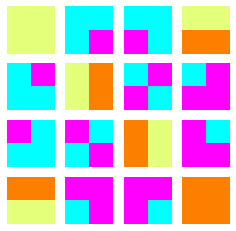

In [10]:
def generate_pics(N:int, B:int):
    """
    Generate batch of B binary images of size N x N returned as array B x N x N.
    """
    return np.random.randint(low=0, high=2, size=(B,N,N)).astype(np.bool)

def generate_all_pics(N:int):
    all_bit_values = np.array([False, True])
    npixels = N**2
    list_of_coordinates = np.meshgrid( *(all_bit_values,)*npixels, indexing='ij' ) 
    return np.stack(list_of_coordinates, axis=-1).reshape((-1,N,N))

def check_if_striped(bpic):
    """
    For batch of images bpic (B x N x N) returns boolean array (N),
    marking if the image consists of stripes (either vertical or horizontal).
    """
    return ( np.all(bpic[:,0,None,:]==bpic, axis=(-1,-2)) 
           | np.all(bpic[:,:,0,None]==bpic, axis=(-1,-2))
           )

def desired_distribution(N: int):
    bpics = generate_all_pics(N=N)
    is_striped = check_if_striped(bpics)
    return is_striped.astype(np.float64)/np.sum(is_striped)

def plot_pic(bpic, maxpics=15**2):
    """
    Show batch of images.
    Arguments: 
        `bpic` is array of shape B x N x N.
        `maxpics` is number of images to show if B is larger than maxpics.
    """
    B, N, M = bpic.shape
    assert N==M
    maxpics = np.minimum(maxpics, B)
    ncols = int(np.ceil(np.sqrt(maxpics)))
    is_striped = check_if_striped(bpic)
    
    fig, axs = plt.subplots(ncols, ncols, figsize=(ncols*1,)*2)
    axs = np.concatenate(axs)
    for k, ax in enumerate(axs):
        if k<maxpics:
            ax.imshow(bpic[k], cmap='Wistia' if is_striped[k] else 'cool', clim=(0,1))
        ax.set_axis_off()
    plt.show()

    
bpics = generate_all_pics(N=2)
# bpics = generate_pics(N=2, B=15**2)
plot_pic(bpics)
# print(f"{desired_distribution(N=2)}")

In [3]:
def U3Gate(t,p,l):
    """
    Universal single qbit gate.
    """
    return jnp.array(([
        [jnp.cos(t/2), -jnp.exp(1j*l)*jnp.sin(t/2)],
        [jnp.exp(1j*p)*jnp.sin(t/2), jnp.exp(1j*(p+l))*jnp.cos(t/2)]
    ]))

def XGate(): return jnp.array([[0.0,1.0],[1.0,0.0]])
def YGate(): return jnp.array([[0.0,1.0j],[-1.0j,0.0]])
def ZGate(): return jnp.array([[1.0,0.0],[0.0,-1.0]])

GATES = {
    'X': XGate(),
    'Y': YGate(),
    'Z': ZGate(),
}

def apply_gate(gate, qbit, phi):
    """
    Apply quantum gate to a statevector for a given qbit.
    Argument:
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert qbit<nq    
    idx = list(range(nq))
    idx[qbit] = nq
    return jnp.einsum(gate, [nq, qbit], phi, list(range(nq)), idx)

def apply_controlled_gate(control, gate, qbit, phi):
    """
    Apply controlled quantum gate to a statevector for a given qbit.
    Argument:
        control: control bit.
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert control<nq and qbit<nq and control!=qbit
    prefix = (slice(None),)*control
    psi0 = phi[prefix+(0,None)] # Action if control is zero.
    idx = list(range(nq))
    idx[qbit] = nq
    psi1 = jnp.einsum(gate, [nq, qbit], phi[prefix+(1,None)], list(range(nq)), idx) # Action if control 1.
    return jnp.concatenate((psi0,psi1), axis=control)

# Small test.
phi = np.arange(4).reshape((2,2))
print("Initial state phi", phi.tolist())
print("X0 phi", apply_gate(XGate(), 0, phi).tolist())
print("X1 phi", apply_gate(XGate(), 1, phi).tolist())
print("C0X1 phi", apply_controlled_gate(0, XGate(), 1, phi).tolist())

Initial state phi [[0, 1], [2, 3]]
X0 phi [[2.0, 3.0], [0.0, 1.0]]
X1 phi [[1.0, 0.0], [3.0, 2.0]]
C0X1 phi [[0.0, 1.0], [3.0, 2.0]]


In [4]:
def apply_entangle(phi):
    """
    Entangle layer in HEA.
    """
    nqbits = phi.ndim
    for q in range(nqbits):
        phi = apply_controlled_gate(q, XGate(), (q+1)%nqbits, phi)
    return phi

def ansatz(theta):
    """
    Compute ansatz for VQE.
    Input:
        theta: array of parameters 3 x nqbits x depth.
    Output:
        statevector: array 2x2x...x2 = 2^nqbits.
    """
    nparam, nqbits, depth = theta.shape
    assert nparam==3
    
    phi = jnp.ones((2,)*nqbits, dtype=np.complex128)/np.power(2, nqbits/2)
    
#     phi = jnp.zeros((2,)*nqbits, dtype=np.complex128)
#     phi[(0,)*nqbits] = 1. 
#     phi = jax.ops.index_update(phi, (0,)*nqbits, 1.) 
    
    for d in range(depth):
        if d>0: phi = apply_entangle(phi)
        for q in range(nqbits):
            phi = apply_gate(U3Gate(*theta[:,q,d]), q, phi)
    return phi

def born_machine(theta):
    """
    Compute ansatz and apply Born's rule.
    Return probability of each outcome.
    """
    psi = ansatz(theta)
    return jnp.abs(psi.flatten())**2

# A small test.
thetas = np.zeros((3,4,1))
born_machine(thetas)

DeviceArray([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
             0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
             0.0625, 0.0625], dtype=float64)

In [5]:
def cross_entropy(p, q, threshold=1e-7):
    return -jnp.sum(p*jnp.log(jnp.maximum(q,threshold)))

@jax.jit
def loss(theta, p_target):
    """
    Computer cross entropy for distribution generated by Born machine and for desired distribution `p_target`.
    """
    nqbits = int(np.log2(p_target.shape[0]))
    theta = theta.reshape((3,nqbits,-1))
    q = born_machine(theta)
    return cross_entropy(p_target, q)

d_loss = jax.jit(jax.grad(loss, 0))

def initialize(N: int, depth: int):
    """
    Create new problem.
    Result:
        `N` - size of the picture.
        `depth` - depth of the neural network.
    """
    nqbits = N**2
    p_target = desired_distribution(N=N)
    theta = np.random.randn(3, nqbits, depth)
    return theta, p_target


Initial loss: 3.0290556087207063
............................Converged: True
Final loss: 1.791759469391944


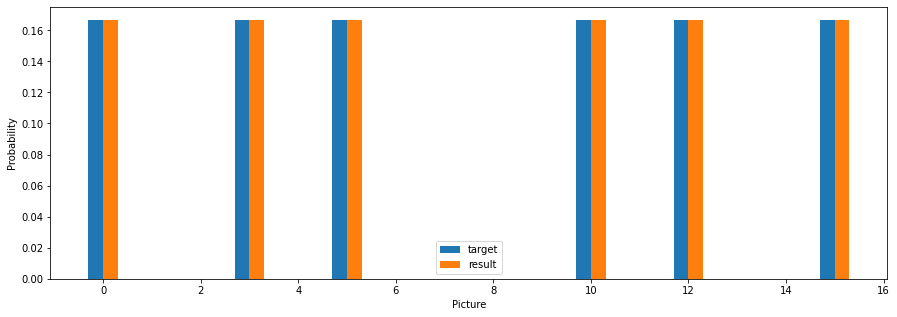

In [6]:
theta0, p_target = initialize(N=2, depth=2)
print(f"Initial loss: {loss(theta0, p_target)}")
res = scipy.optimize.minimize(fun=loss
                              , jac=d_loss
                              , x0=theta0.flatten()
                              , args=(p_target,)
                              , callback=lambda _: print('.',end=''))
print(f"Converged:", res.success)
theta = res.x.reshape(theta0.shape)
q = born_machine(theta)
print(f"Final loss: {res.fun}")
fig, ax = plt.subplots(figsize=(15,5))
width=0.3
x=np.arange(len(q))
ax.bar(x-width/2, p_target, width=width, label='target')
ax.bar(x+width/2, q, width=width, label='result')
ax.set_xlabel('Picture')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [7]:
def samples_to_indices(samples):
    samples = samples.reshape((samples.shape[0],-1)).T.astype(np.int)
    return jnp.ravel_multi_index(samples, (2,)*samples.shape[0], mode='wrap')
    
def cross_entropy_stat(samples, q, threshold=1e-7):
    indices = samples_to_indices(samples)
    return -jnp.sum(jnp.log(q[indices]))/samples.shape[0]

@jax.jit
def loss_b(theta, samples):
    B, N, N = samples.shape
    nqbits = N**2    
    theta = theta.reshape((3,nqbits,-1))
    q = born_machine(theta)
    return cross_entropy_stat(samples, q)

d_loss_b = jax.jit(jax.grad(loss_b, 0))

def create_batch(N: int, B: int):
    """
    Create a batch of samples. 
    Result:
        `N` - size of the picture.
        `B` - number of samples in the batch.
    """
    samples = generate_pics(N=N, B=B)
    cl = check_if_striped(samples)   
    return samples[cl]


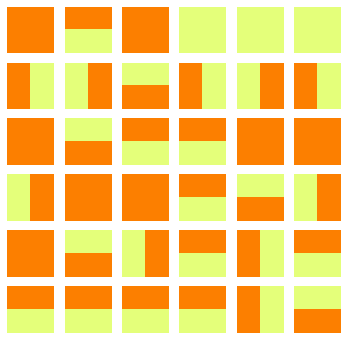

Initial loss: 2.775842819414761
............................................................................................Converged: True
Final loss: 1.7618946374677444


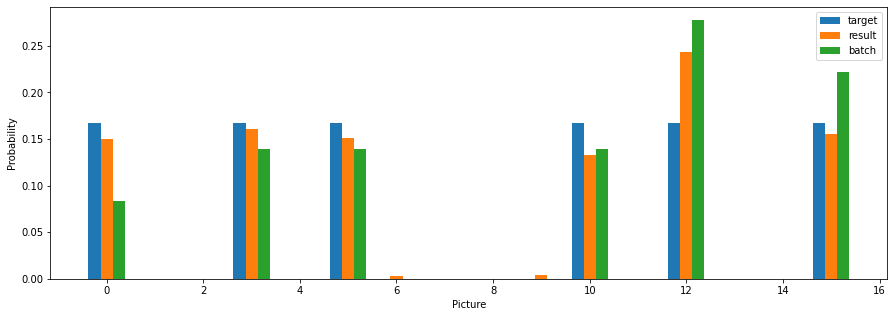

In [8]:
# Single batch version. BAD generalization.
theta0, p_target = initialize(N=2, depth=2)
samples = create_batch(N=2, B=100)
plot_pic(samples)
values, counts = np.unique(samples_to_indices(samples), return_counts=True)
p_b = np.zeros_like(p_target)
for v, c in zip(values, counts): p_b[v]=c
p_b /= samples.shape[0]
print(f"Initial loss: {loss_b(theta0, samples)}")
res = scipy.optimize.minimize(fun=loss_b
                              , jac=d_loss_b
                              , x0=theta0.flatten()
                              , args=(samples, )
                              , callback=lambda _: print('.',end=''))
print(f"Converged:", res.success)
theta = res.x.reshape(theta0.shape)
q = born_machine(theta)
print(f"Final loss: {res.fun}")
fig, ax = plt.subplots(figsize=(15,5))
width=0.25
x=np.arange(len(q))
ax.bar(x-width, p_target, width=width, label='target')
ax.bar(x, q, width=width, label='result')
ax.bar(x+width, p_b, width=width, label='batch')
ax.set_xlabel('Picture')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

Initial loss: 3.0745386427455434
.....Epoch 0: 3.8681653694482514
.....Epoch 1: 4.215989947270673
.....Epoch 2: 5.704440136153874
.....Epoch 3: 6.713887610404238
.....Epoch 4: 6.151077126226506
.....Epoch 5: 7.171031561698307
.....Epoch 6: 7.729211775000459
.....Epoch 7: 8.296538452492921
.....Epoch 8: 8.346162889899798
.....Epoch 9: 9.828720099892378
.....Epoch 10: 10.222107925540312
.....Epoch 11: 8.1244788341807
.....Epoch 12: 8.799379327396098
.....Epoch 13: 9.06121742419704
.....Epoch 14: 8.981096842670235
.....Epoch 15: 9.180776767156484
.....Epoch 16: 10.042572591794825
.....Epoch 17: 9.931625995209416
.....Epoch 18: 9.677492429883664
.....Epoch 19: 10.11108814650561


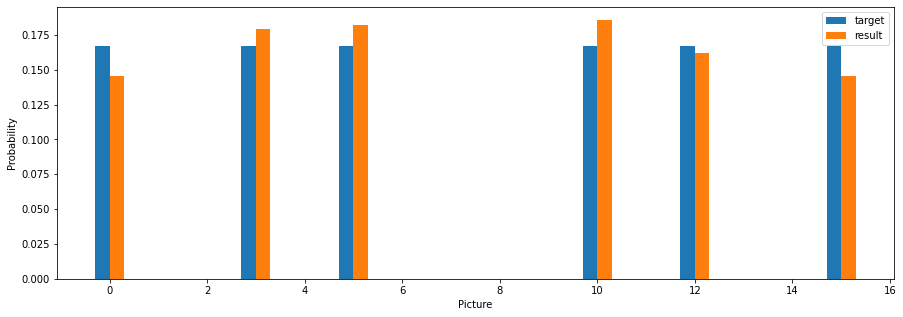

In [9]:
N=2
theta0, p_target = initialize(N=N, depth=2)
test_set = generate_pics(N=N, B=100)
print(f"Initial loss: {loss_b(theta0, test_set)}")
theta = theta0.flatten()
for epoch in range(20):
    train_set = create_batch(N=2, B=100)
    res = scipy.optimize.minimize(fun=loss_b
                                  , jac=d_loss_b
                                  , x0=theta
                                  , args=(train_set, )
                                  , callback=lambda _: print('.',end='')
                                  , options = { 'maxiter': 5 }
                                 )
    theta = res.x
    print(f"Epoch {epoch}: {loss_b(theta.reshape(theta0.shape), test_set)}")
theta = theta.reshape(theta0.shape)
q = born_machine(theta)
fig, ax = plt.subplots(figsize=(15,5))
width=0.3
x=np.arange(len(q))
ax.bar(x-width/2, p_target, width=width, label='target')
ax.bar(x+width/2, q, width=width, label='result')
ax.set_xlabel('Picture')
ax.set_ylabel('Probability')
ax.legend()
plt.show()